In [44]:
!pip install catboost

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import time
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
import collections
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [46]:
df= pd.read_csv("/content/Customer.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [47]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [48]:
df.isnull().sum().max()

0

In [49]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [50]:
# Assuming 'Churn' represents the target variable (yes/no)
print('No', round(df['Churn'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Yes', round(df['Churn'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No 73.46 % of the dataset
Yes 26.54 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No || 1: Yes)')

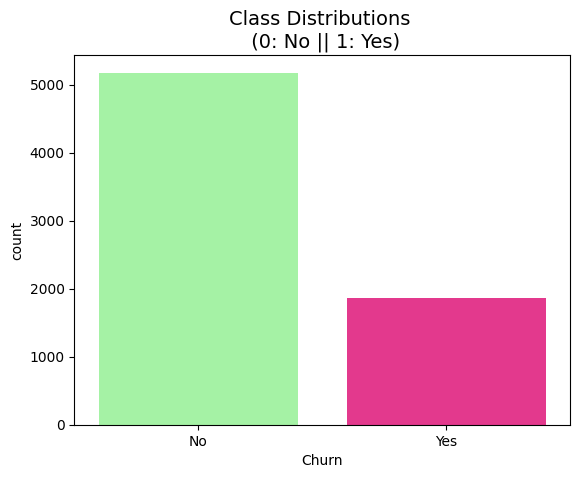

In [51]:
colors = ["#98FF98", "#FF1D8D"]

# The first argument to sns.countplot() is 'x', which should be the column to count.
# The 'data' argument should be provided as a keyword argument.
# Changed 'Class' to 'Churn' as the target variable represents yes/no
sns.countplot(x='Churn', data=df, palette=colors)
plt.title('Class Distributions \n (0: No || 1: Yes)', fontsize=14)

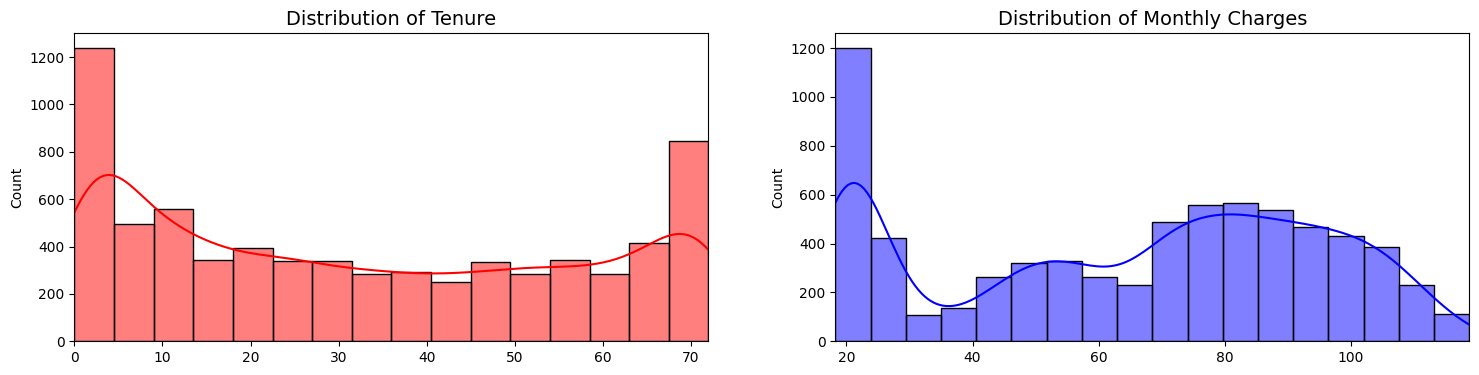

In [52]:
# Convert 'TotalCharges' to numeric if it's not already
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

# Tenure distribution
tenure_val = df['tenure'].values
sns.histplot(tenure_val, ax=ax[0], color='r', kde=True)  # Using histplot instead of distplot (deprecated)
ax[0].set_title('Distribution of Tenure', fontsize=14)
ax[0].set_xlim([min(tenure_val), max(tenure_val)])

# Monthly Charges distribution
monthly_charges_val = df['MonthlyCharges'].values
sns.histplot(monthly_charges_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Monthly Charges', fontsize=14)
ax[1].set_xlim([min(monthly_charges_val), max(monthly_charges_val)])

plt.show()

In [53]:
# Instead of scaling 'Amount' and 'Time', which are likely not in your dataset,
# try scaling other numerical features relevant to customer churn,
# such as 'tenure', 'MonthlyCharges', or 'TotalCharges'.
from sklearn.preprocessing import RobustScaler # Importing RobustScaler

# Initializing RobustScaler: This line was missing
rob_scaler = RobustScaler()

# Example:
df['scaled_tenure'] = rob_scaler.fit_transform(df['tenure'].values.reshape(-1,1))
df['scaled_monthly_charges'] = rob_scaler.fit_transform(df['MonthlyCharges'].values.reshape(-1,1))
df['scaled_total_charges'] = rob_scaler.fit_transform(df['TotalCharges'].values.reshape(-1,1))

# Remove the original columns if needed
# df.drop(['tenure', 'MonthlyCharges', 'TotalCharges'], axis=1, inplace=True)

In [54]:
# Instead of scaling 'Amount' and 'Time', which are likely not in your dataset,
# try scaling other numerical features relevant to customer churn,
# such as 'tenure', 'MonthlyCharges', or 'TotalCharges'.
from sklearn.preprocessing import RobustScaler # Importing RobustScaler
rob_scaler = RobustScaler() # Initializing RobustScaler

# Example:
df['scaled_tenure'] = rob_scaler.fit_transform(df['tenure'].values.reshape(-1,1))
df['scaled_monthly_charges'] = rob_scaler.fit_transform(df['MonthlyCharges'].values.reshape(-1,1))
df['scaled_total_charges'] = rob_scaler.fit_transform(df['TotalCharges'].values.reshape(-1,1))

# Now use the scaled features
scaled_tenure = df['scaled_tenure']
scaled_monthly_charges = df['scaled_monthly_charges']
scaled_total_charges = df['scaled_total_charges']

# You can drop the original or scaled columns if needed
# df.drop(['tenure', 'MonthlyCharges', 'TotalCharges'], axis=1, inplace=True)
# df.drop(['scaled_tenure', 'scaled_monthly_charges', 'scaled_total_charges'], axis=1, inplace=True)

# If you need to insert the scaled columns at specific positions:
# The columns already exist, so just reorder them if needed
# Example: Reorder columns to have scaled features at the beginning
cols = ['scaled_tenure', 'scaled_monthly_charges', 'scaled_total_charges'] + [col for col in df.columns if col not in ['scaled_tenure', 'scaled_monthly_charges', 'scaled_total_charges']]
df = df[cols]


# Amount and Time were likely placeholders, now replaced with the actual scaled features

df.head()

,scaled_tenure,scaled_monthly_charges,scaled_total_charges,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,-0.608696,-0.745170,-0.403038,7590-VHVEG,Female,0,Yes,No,1,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,0.108696,-0.246550,0.145000,5575-GNVDE,Male,0,No,No,34,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,-0.586957,-0.303588,-0.379963,3668-QPYBK,Male,0,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,0.347826,-0.516099,0.130633,7795-CFOCW,Male,0,No,No,45,No,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,-0.586957,0.006440,-0.367144,9237-HQITU,Female,0,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [55]:
# Option 2: Impute NaN with the most frequent value (if appropriate for your data)
# !pip install --upgrade scikit-learn
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
# Pass a Series (1-dimensional) instead of a DataFrame (2-dimensional)
df['Churn'] = imputer.fit_transform(df['Churn'].values.reshape(-1, 1))[:, 0] # or df['Churn'] = imputer.fit_transform(df[['Churn']])[:, 0]

# Now proceed with splitting the data
X = df.drop('Churn', axis=1)  # Dropping 'Churn' instead of 'Class'
y = df['Churn']             # Selecting 'Churn' instead of 'Class'


sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index] # Added this line to assign original_ytrain and original_ytest


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [1408 1409 1411 ... 7040 7041 7042] Test: [   0    1    2 ... 1406 1407 1410]
Train: [   0    1    2 ... 7040 7041 7042] Test: [1408 1409 1411 ... 2862 2869 2871]
Train: [   0    1    2 ... 7040 7041 7042] Test: [2805 2806 2807 ... 4266 4269 4272]
Train: [   0    1    2 ... 7040 7041 7042] Test: [4207 4208 4209 ... 5643 5644 5646]
Train: [   0    1    2 ... 5643 5644 5646] Test: [5625 5626 5627 ... 7040 7041 7042]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.73469388 0.26530612]
[0.734375 0.265625]


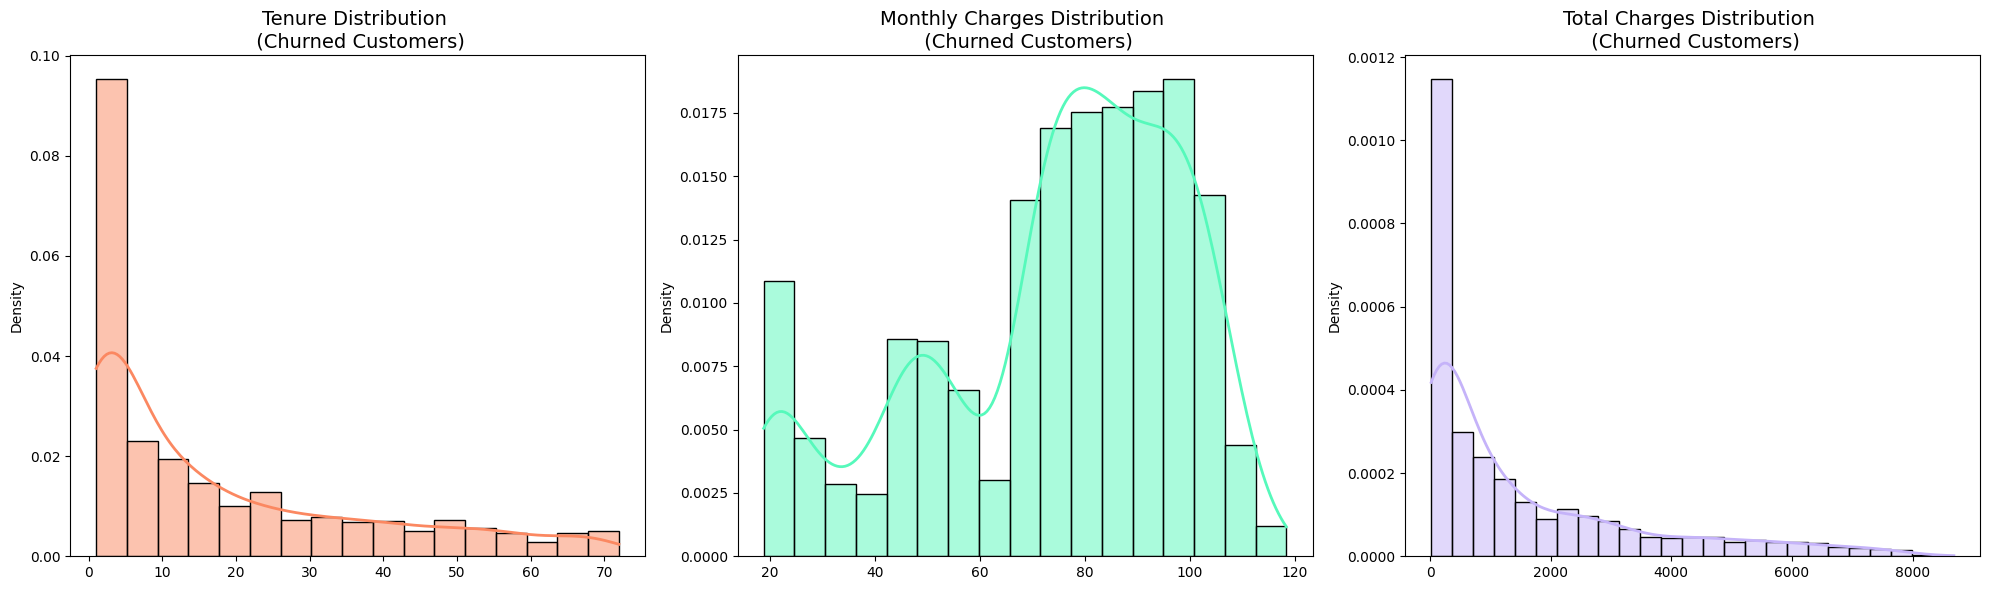

In [56]:
# Convert 'TotalCharges' to numeric if it's not already
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Filter data for customers who churned
churned_customers = df[df['Churn'] == 'Yes']

# Visualization
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Tenure distribution for churned customers
tenure_churned = churned_customers['tenure'].values
sns.histplot(tenure_churned, ax=ax1, kde=True, stat="density", color='#FB8861', line_kws={'linewidth': 2})
ax1.set_title('Tenure Distribution \n (Churned Customers)', fontsize=14)

# MonthlyCharges distribution for churned customers
monthly_charges_churned = churned_customers['MonthlyCharges'].values
sns.histplot(monthly_charges_churned, ax=ax2, kde=True, stat="density", color='#56F9BB', line_kws={'linewidth': 2})
ax2.set_title('Monthly Charges Distribution \n (Churned Customers)', fontsize=14)

# TotalCharges distribution for churned customers
total_charges_churned = churned_customers['TotalCharges'].values
sns.histplot(total_charges_churned, ax=ax3, kde=True, stat="density", color='#C5B3F9', line_kws={'linewidth': 2})
ax3.set_title('Total Charges Distribution \n (Churned Customers)', fontsize=14)

plt.tight_layout()
plt.show()

In [57]:
# Convert 'TotalCharges' to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Filter churned customers
churned_customers = df[df['Churn'] == 'Yes']

# -----> Removing outliers for 'tenure'
tenure_values = churned_customers['tenure'].values
q25, q75 = np.percentile(tenure_values, 25), np.percentile(tenure_values, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
tenure_iqr = q75 - q25
print('iqr: {}'.format(tenure_iqr))

tenure_cut_off = tenure_iqr * 1.5
tenure_lower, tenure_upper = q25 - tenure_cut_off, q75 + tenure_cut_off
print('Cut Off: {}'.format(tenure_cut_off))
print('Tenure Lower: {}'.format(tenure_lower))
print('Tenure Upper: {}'.format(tenure_upper))

outliers = [x for x in tenure_values if x < tenure_lower or x > tenure_upper]
print('Feature Tenure Outliers for Churned Customers: {}'.format(len(outliers)))
print('Outliers: {}'.format(outliers))

df = df.drop(df[(df['tenure'] > tenure_upper) | (df['tenure'] < tenure_lower)].index)
print('Remaining instances after tenure outlier removal: {}'.format(len(df)))
print('----' * 20)

# -----> Removing outliers for 'MonthlyCharges'
monthly_charges_values = churned_customers['MonthlyCharges'].values
q25, q75 = np.percentile(monthly_charges_values, 25), np.percentile(monthly_charges_values, 75)
monthly_charges_iqr = q75 - q25

monthly_charges_cut_off = monthly_charges_iqr * 1.5
monthly_charges_lower, monthly_charges_upper = q25 - monthly_charges_cut_off, q75 + monthly_charges_cut_off
print('Monthly Charges Lower: {}'.format(monthly_charges_lower))
print('Monthly Charges Upper: {}'.format(monthly_charges_upper))

outliers = [x for x in monthly_charges_values if x < monthly_charges_lower or x > monthly_charges_upper]
print('Monthly Charges Outliers: {}'.format(len(outliers)))
print('Outliers: {}'.format(outliers))

df = df.drop(df[(df['MonthlyCharges'] > monthly_charges_upper) | (df['MonthlyCharges'] < monthly_charges_lower)].index)
print('Remaining instances after MonthlyCharges outlier removal: {}'.format(len(df)))
print('----' * 20)

# -----> Removing outliers for 'TotalCharges'
total_charges_values = churned_customers['TotalCharges'].values
q25, q75 = np.percentile(total_charges_values, 25), np.percentile(total_charges_values, 75)
total_charges_iqr = q75 - q25

total_charges_cut_off = total_charges_iqr * 1.5
total_charges_lower, total_charges_upper = q25 - total_charges_cut_off, q75 + total_charges_cut_off
print('Total Charges Lower: {}'.format(total_charges_lower))
print('Total Charges Upper: {}'.format(total_charges_upper))

outliers = [x for x in total_charges_values if x < total_charges_lower or x > total_charges_upper]
print('Total Charges Outliers: {}'.format(len(outliers)))
print('Outliers: {}'.format(outliers))

df = df.drop(df[(df['TotalCharges'] > total_charges_upper) | (df['TotalCharges'] < total_charges_lower)].index)
print('Remaining instances after TotalCharges outlier removal: {}'.format(len(df)))
print('----' * 20)

Quartile 25: 2.0 | Quartile 75: 29.0
iqr: 27.0
Cut Off: 40.5
Tenure Lower: -38.5
Tenure Upper: 69.5
Feature Tenure Outliers for Churned Customers: 23
Outliers: [70, 71, 70, 70, 71, 72, 72, 70, 72, 71, 72, 72, 70, 70, 70, 71, 70, 70, 71, 71, 72, 70, 70]
Remaining instances after tenure outlier removal: 6392
--------------------------------------------------------------------------------
Monthly Charges Lower: -0.9250000000000043
Monthly Charges Upper: 151.275
Monthly Charges Outliers: 0
Outliers: []
Remaining instances after MonthlyCharges outlier removal: 6392
--------------------------------------------------------------------------------
Total Charges Lower: -3160.7000000000003
Total Charges Upper: 5626.5
Total Charges Outliers: 109
Outliers: [7611.85, 6603.0, 7007.6, 6396.45, 6786.4, 6985.65, 5794.65, 6125.4, 6017.65, 7250.15, 6413.65, 6215.35, 7532.15, 6383.35, 6127.6, 6448.05, 8127.6, 5961.1, 7133.25, 6254.2, 6547.7, 6873.75, 5769.75, 6710.5, 5918.8, 6615.15, 6937.95, 5940.85, 588

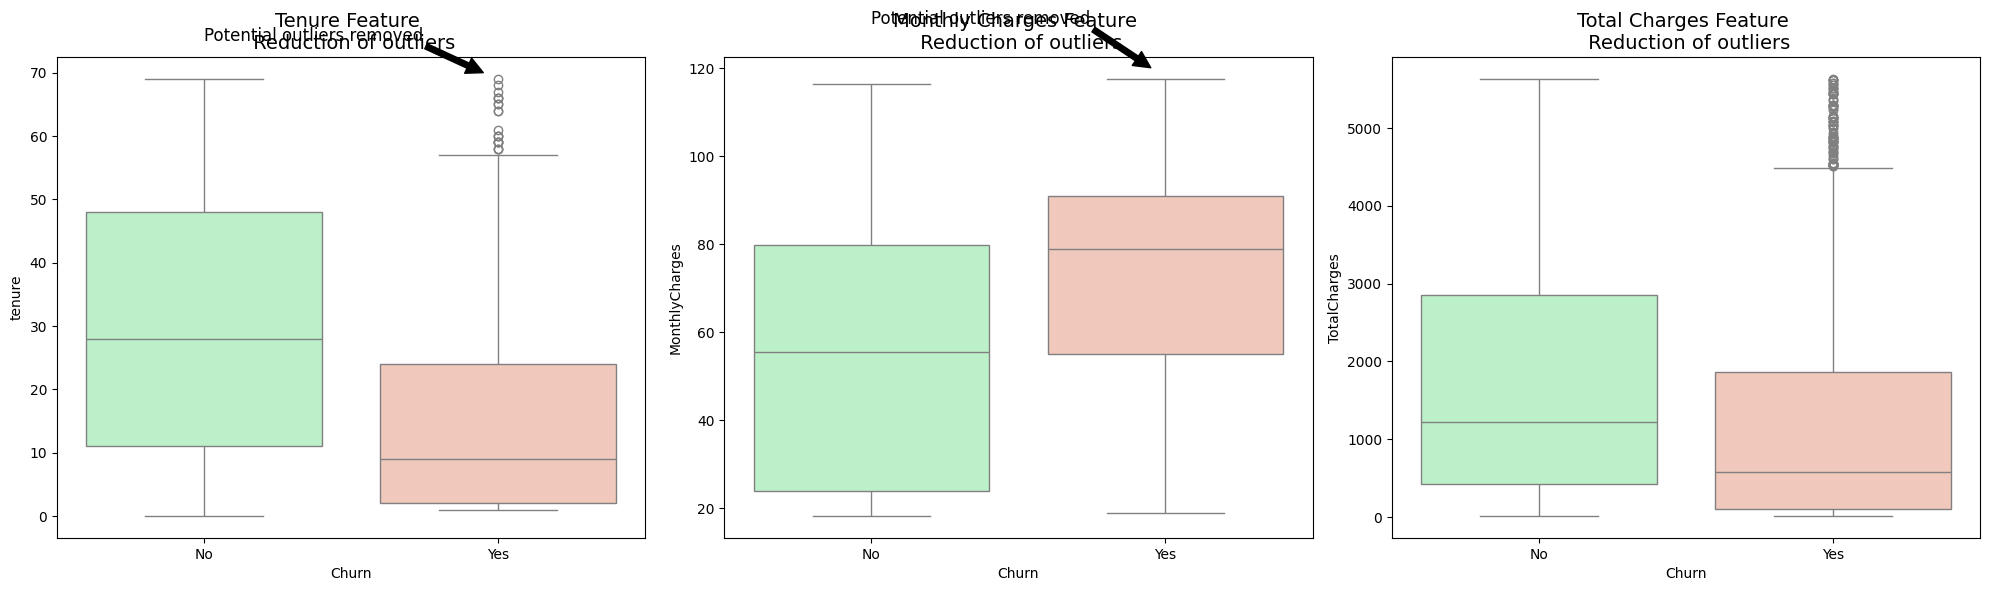

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure clean dataset
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Define colors for the boxplots
colors = ['#B3F9C5', '#f9c5b3']

# Create boxplots
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Feature: Tenure
sns.boxplot(x="Churn", y="tenure", data=df, ax=ax1, palette=colors)
ax1.set_title("Tenure Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Potential outliers removed', xy=(0.95, 70), xytext=(0, 75),
             arrowprops=dict(facecolor='black'), fontsize=12)

# Feature: MonthlyCharges
sns.boxplot(x="Churn", y="MonthlyCharges", data=df, ax=ax2, palette=colors)
ax2.set_title("Monthly Charges Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Potential outliers removed', xy=(0.95, 120), xytext=(0, 130),
             arrowprops=dict(facecolor='black'), fontsize=12)

# Feature: TotalCharges
sns.boxplot(x="Churn", y="TotalCharges", data=df, ax=ax3, palette=colors)
ax3.set_title("Total Charges Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Potential outliers removed', xy=(0.95, 8000), xytext=(0, 8500),
             arrowprops=dict(facecolor='black'), fontsize=12)

plt.tight_layout()
plt.show()

In [59]:
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Prepare the dataset
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['tenure', 'MonthlyCharges', 'TotalCharges'], inplace=True)

# Encode non-numeric features
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != 'Churn':  # Exclude the target variable
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Define X (features) and y (target)
X = df.drop('Churn', axis=1)
y = LabelEncoder().fit_transform(df['Churn'])  # Encode the target variable

# Scale the features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)
t1 = time.time()
print("T-SNE took {:.2f} seconds".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
t1 = time.time()
print("PCA took {:.2f} seconds".format(t1 - t0))

# Truncated SVD Implementation
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(X_scaled)
t1 = time.time()
print("Truncated SVD took {:.2f} seconds".format(t1 - t0))

T-SNE took 90.65 seconds
PCA took 0.00 seconds
Truncated SVD took 0.11 seconds


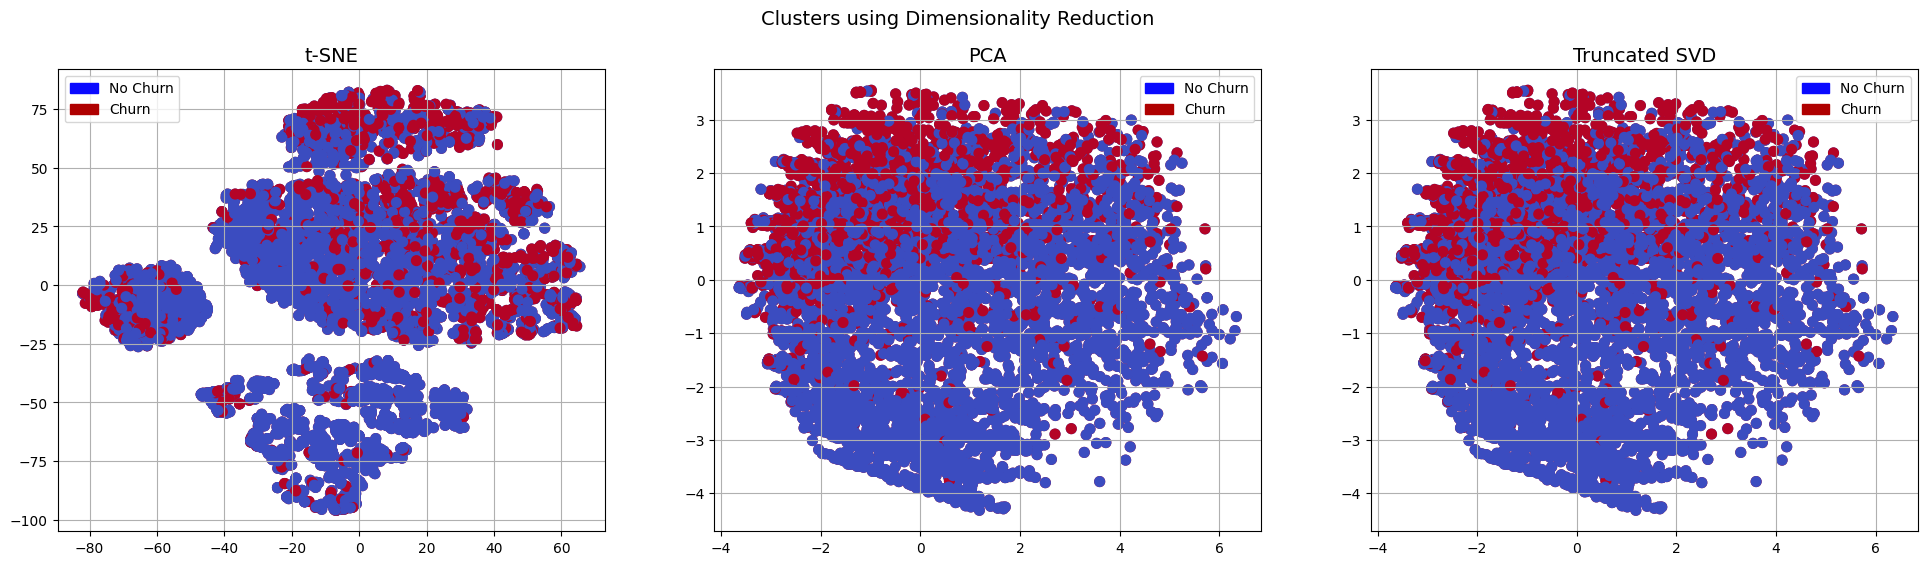

In [60]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

# Define legend patches
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Churn')
red_patch = mpatches.Patch(color='#AF0000', label='Churn')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 0), cmap='coolwarm', label='No Churn', linewidths=2)
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 1), cmap='coolwarm', label='Churn', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 0), cmap='coolwarm', label='No Churn', linewidths=2)
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 1), cmap='coolwarm', label='Churn', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# Truncated SVD scatter plot
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 0), cmap='coolwarm', label='No Churn', linewidths=2)
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 1), cmap='coolwarm', label='Churn', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# splitting

In [61]:
# Undersampling before cross validating (prone to overfit)
X = df.drop('Churn', axis=1)
y = df['Churn']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Classifiers

In [64]:
# Let's implement simple classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [65]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 78.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 68.0 % accuracy score
Classifiers:  SVC Has a training score of 70.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 71.0 % accuracy score


In [66]:
# Prepare the dataset
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')  # Exclude target variable

# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define X (features) and y (target)
X = df.drop('Churn', axis=1)
y = LabelEncoder().fit_transform(df['Churn'])  # Encode target variable

# Identify categorical feature indices
cat_feature_indices = [X.columns.get_loc(col) for col in categorical_cols]

In [67]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define CatBoost parameter grid
catboost_params = {
    'iterations': [500, 1000],
    'learning_rate': [0.03, 0.1],
    'depth': [6, 8, 10]
}

# Randomized Search with CatBoost
random_catboost = RandomizedSearchCV(
    CatBoostClassifier(random_state=42, verbose=0),
    catboost_params,
    n_iter=5,
    random_state=42
)
random_catboost.fit(X, y, cat_features=cat_feature_indices)

# Retrieve best estimator
catboost_clf = random_catboost.best_estimator_


In [68]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
random_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=5, random_state=42)
random_log_reg.fit(X_train, y_train)
log_reg = random_log_reg.best_estimator_

# K-Nearest Neighbors
knears_params = {"n_neighbors": list(range(2, 5, 1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
random_knears = RandomizedSearchCV(KNeighborsClassifier(), knears_params, n_iter=5, random_state=42)
random_knears.fit(X_train, y_train)
knears_neighbors = random_knears.best_estimator_

# Decision Tree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2, 4, 1)),
               "min_samples_leaf": list(range(5, 7, 1))}
random_tree = RandomizedSearchCV(DecisionTreeClassifier(), tree_params, n_iter=5, random_state=42)
random_tree.fit(X_train, y_train)
tree_clf = random_tree.best_estimator_

In [69]:
# Overfitting Case

# Cross-validation for different classifiers
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score: ', round(knears_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score: ', round(tree_score.mean() * 100, 2).astype(str) + '%')

catboost_score = cross_val_score(catboost_clf, X_train, y_train, cv=5)
print('CatBoost Classifier Cross Validation Score: ', round(catboost_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  78.24%
Knears Neighbors Cross Validation Score:  70.24%
DecisionTree Classifier Cross Validation Score:  75.59%
CatBoost Classifier Cross Validation Score:  77.24%


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

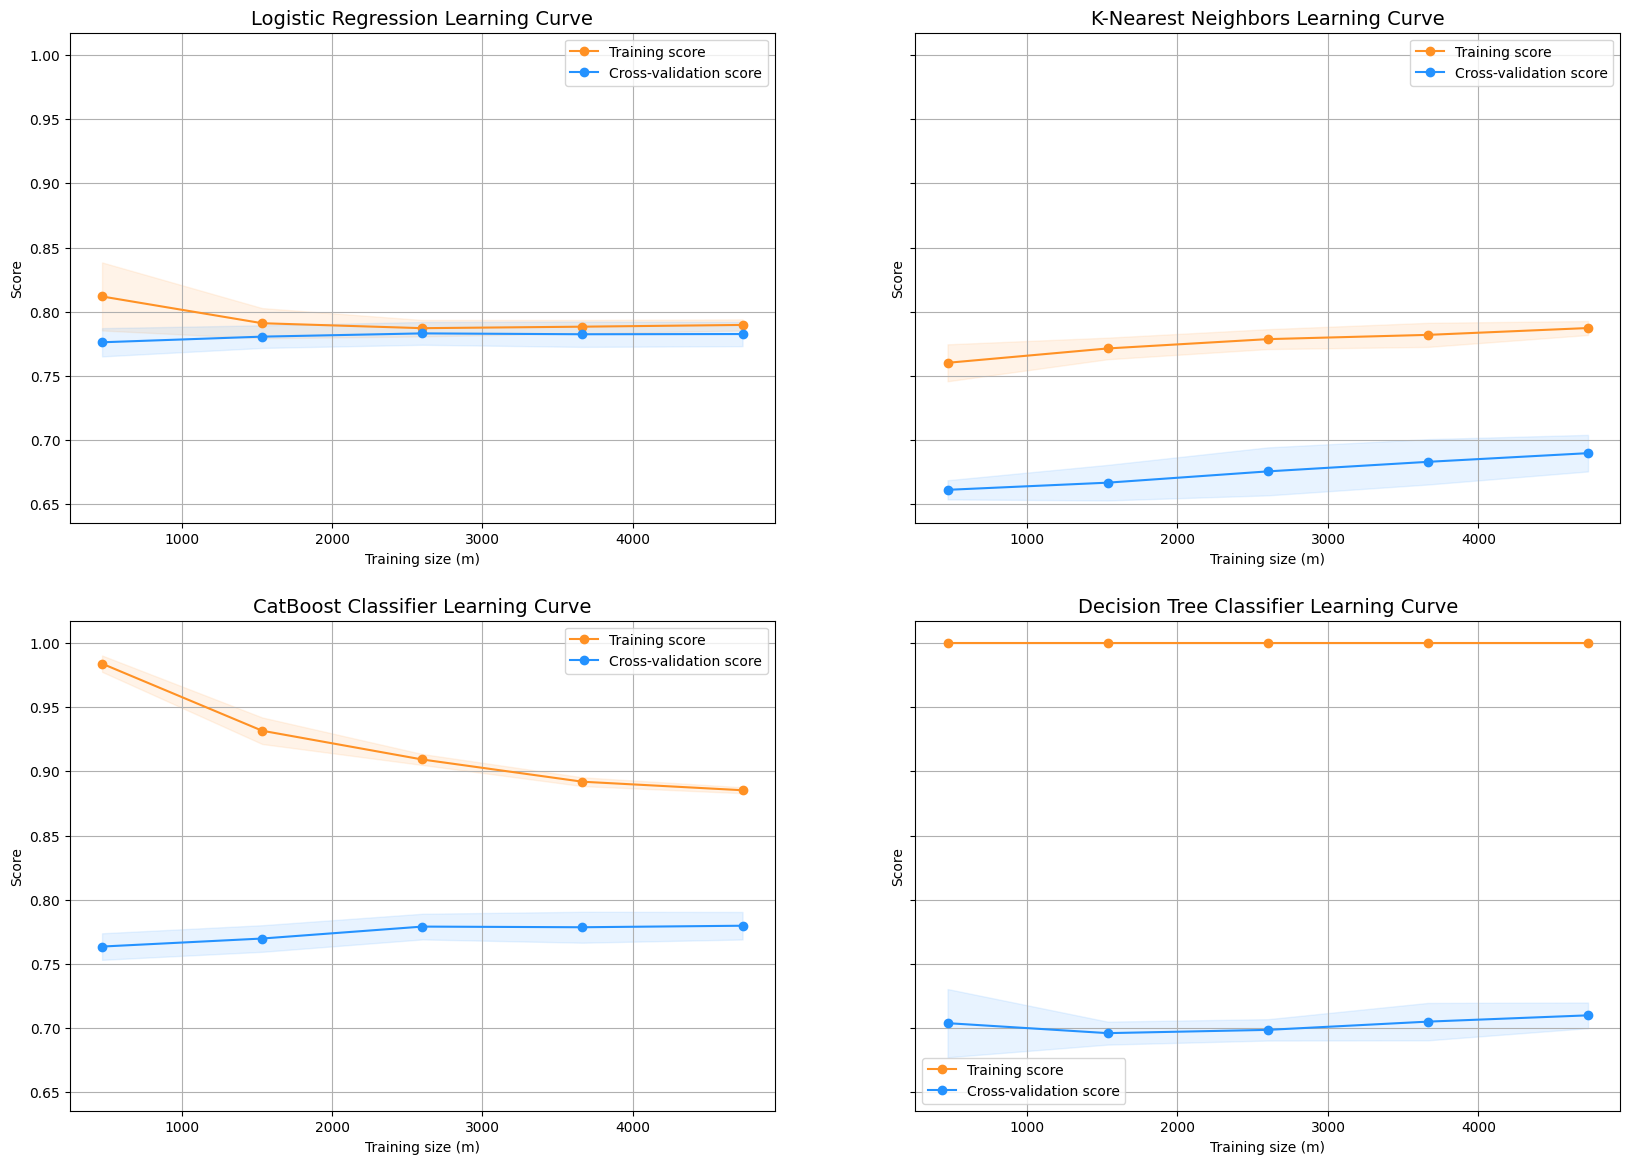

In [70]:
def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)

    # First Estimator (Logistic Regression)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

    # Second Estimator (KNeighbors Classifier)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("K-Nearest Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")

    # Third Estimator (CatBoost Classifier)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("CatBoost Classifier Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")

    # Fourth Estimator (Decision Tree Classifier)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")

    return plt

# Create classifiers
log_reg = LogisticRegression(max_iter=1000, random_state=42)
knn = KNeighborsClassifier()
catboost = CatBoostClassifier(random_state=42, verbose=0)
dtc = DecisionTreeClassifier(random_state=42)

# Assuming X and y are your features and target
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Plot the learning curve
plot_learning_curve(log_reg, knn, catboost, dtc, X, y, cv=cv)

In [71]:
from sklearn.model_selection import cross_val_predict

# Predictions for each classifier
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")
knn_pred = cross_val_predict(knn, X_train, y_train, cv=5)
catboost_pred = cross_val_predict(catboost_clf, X_train, y_train, cv=5, method="predict_proba")[:, 1]  # Assuming binary classification
tree_pred = cross_val_predict(dtc, X_train, y_train, cv=5)

# Create a DataFrame with predictions and classifier names
predictions_df = pd.DataFrame({
    'Logistic Regression': log_reg_pred,
    'K-Nearest Neighbors': knn_pred,
    'CatBoost': catboost_pred,
    'Decision Tree': tree_pred
})

# Show the DataFrame with all predictions
print(predictions_df.head())


   Logistic Regression K-Nearest Neighbors  CatBoost Decision Tree
0            -0.441775                  No  0.432654            No
1            -0.083982                  No  0.603432           Yes
2            -2.048934                  No  0.080557            No
3            -0.709560                 Yes  0.310818            No
4            -2.703461                  No  0.093799            No


0:	learn: 0.6361820	total: 4.18ms	remaining: 4.18s
1:	learn: 0.5918009	total: 15.7ms	remaining: 7.81s
2:	learn: 0.5602005	total: 20.2ms	remaining: 6.7s
3:	learn: 0.5353821	total: 31.7ms	remaining: 7.88s
4:	learn: 0.5154817	total: 37.4ms	remaining: 7.45s
5:	learn: 0.5015881	total: 44.4ms	remaining: 7.35s
6:	learn: 0.4895522	total: 51.1ms	remaining: 7.25s
7:	learn: 0.4794035	total: 59.1ms	remaining: 7.33s
8:	learn: 0.4713467	total: 62.8ms	remaining: 6.92s
9:	learn: 0.4642058	total: 65.6ms	remaining: 6.5s
10:	learn: 0.4587001	total: 68.4ms	remaining: 6.15s
11:	learn: 0.4537041	total: 72ms	remaining: 5.92s
12:	learn: 0.4507776	total: 74.8ms	remaining: 5.68s
13:	learn: 0.4465569	total: 82ms	remaining: 5.78s
14:	learn: 0.4425456	total: 87.3ms	remaining: 5.73s
15:	learn: 0.4396254	total: 99.3ms	remaining: 6.11s
16:	learn: 0.4366974	total: 114ms	remaining: 6.57s
17:	learn: 0.4341652	total: 119ms	remaining: 6.48s
18:	learn: 0.4317070	total: 122ms	remaining: 6.3s
19:	learn: 0.4291832	total: 125m

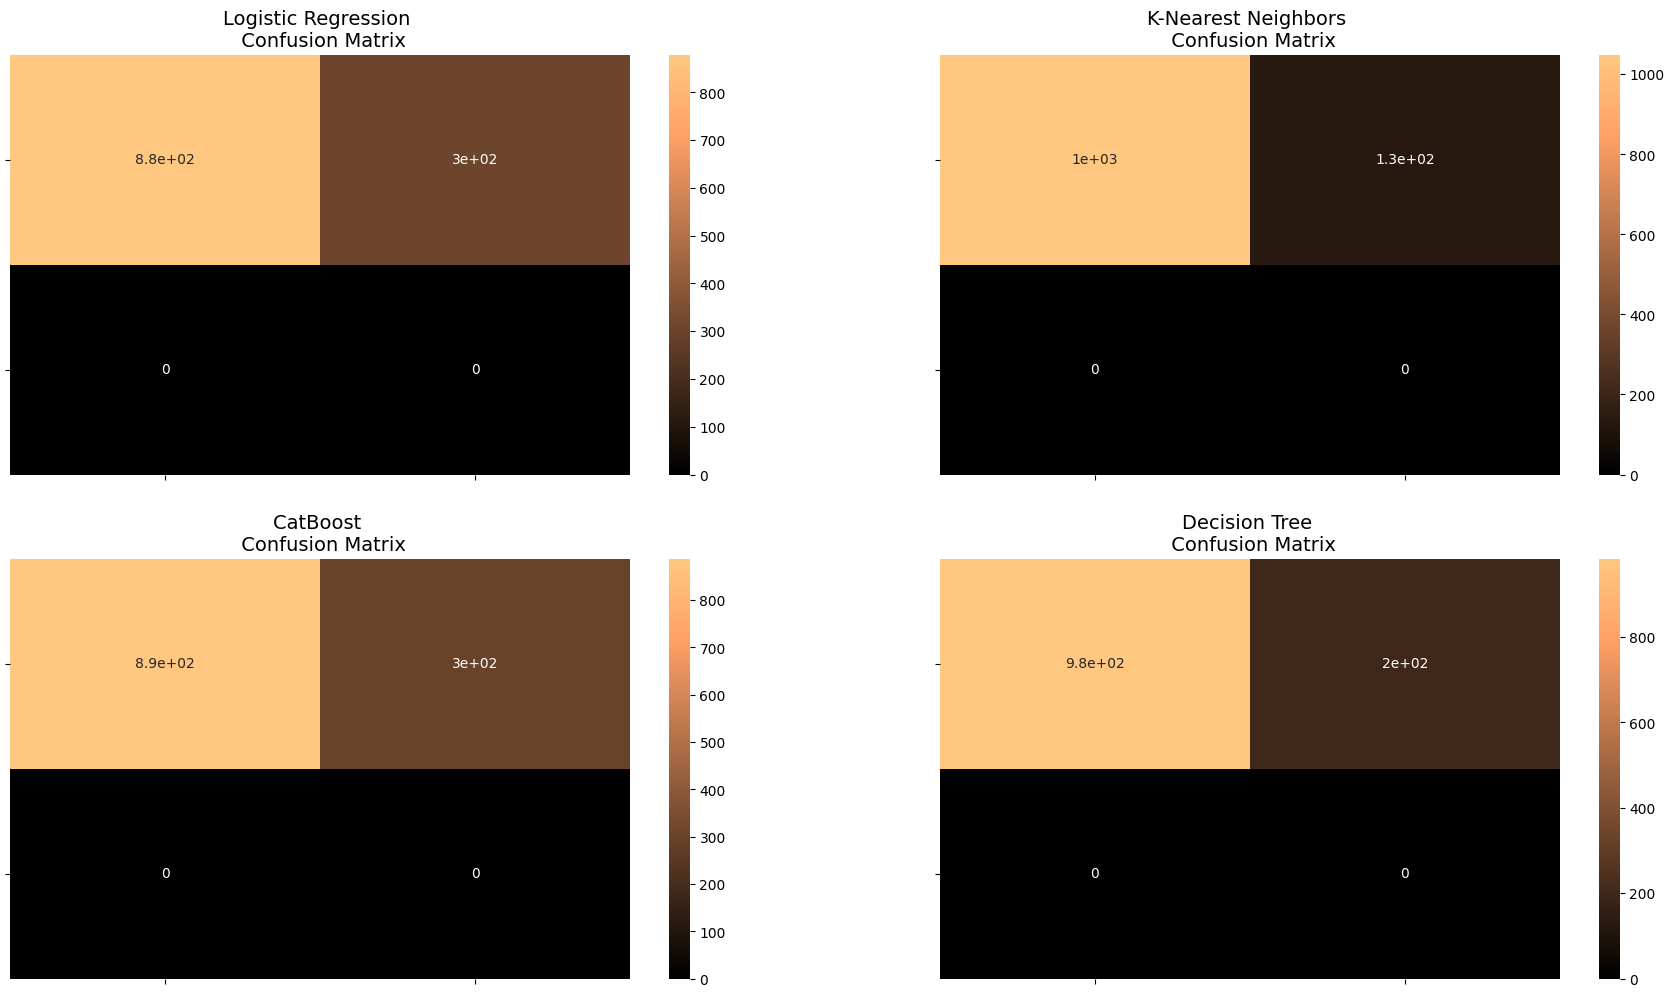

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
catboost = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss')
catboost.fit(X_train, y_train)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_catboost = catboost.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)
y_pred_log_reg = np.where(y_pred_log_reg == 'Yes', 1, 0)
y_pred_knear = np.where(y_pred_knear == 'Yes', 1, 0)
y_pred_tree = np.where(y_pred_tree == 'Yes', 1, 0)
y_pred_catboost = np.where(y_pred_catboost == 'Yes', 1, 0)
y_test = np.where(y_test == 'Yes', 1, 0)

# Confusion matrices
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
catboost_cf = confusion_matrix(y_test, y_pred_catboost)
tree_cf = confusion_matrix(y_test, y_pred_tree)
# Plotting confusion matrices
fig, ax = plt.subplots(2, 2, figsize=(22, 12))
# Logistic Regression Confusion Matrix
sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

# K-Nearest Neighbors Confusion Matrix
sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("K-Nearest Neighbors \n Confusion Matrix", fontsize=14)
ax[0, 1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 1].set_yticklabels(['', ''], fontsize=14, rotation=360)

# CatBoost Confusion Matrix
sns.heatmap(catboost_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1, 0].set_title("CatBoost \n Confusion Matrix", fontsize=14)
ax[1, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

# Decision Tree Confusion Matrix
sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("Decision Tree \n Confusion Matrix", fontsize=14)
ax[1, 1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1, 1].set_yticklabels(['', ''], fontsize=14, rotation=360)

# Show the plot
plt.show()

In [75]:
from sklearn.metrics import classification_report
print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))
print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))
print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_catboost))
print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      1183
           1       0.00      0.00      0.00         0

    accuracy                           0.74      1183
   macro avg       0.50      0.37      0.43      1183
weighted avg       1.00      0.74      0.85      1183

KNears Neighbors:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1183
           1       0.00      0.00      0.00         0

    accuracy                           0.89      1183
   macro avg       0.50      0.44      0.47      1183
weighted avg       1.00      0.89      0.94      1183

Support Vector Classifier:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      1183
           1       0.00      0.00      0.00         0

    accuracy                           0.75      1183
   macro avg       0.50      0.38      0.43      1183
weighted

# RN-SMOTE

In [76]:
from math import log
from sklearn.cluster import DBSCAN

In [77]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

In [80]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Training set:", X_train_smote.shape, y_train_smote.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (4992, 23) (4992,)
Validation set: (1182, 23) (1182,)
Test set: (1183, 23) (1183,)


In [94]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [95]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=2)
labels_train = dbscan.fit_predict(X_train_scaled)
non_noise_indices_train = labels_train != -1
X_train_cleaned = X_train_scaled[non_noise_indices_train]
y_train_cleaned = y_train_smote[non_noise_indices_train]
labels_val = dbscan.fit_predict(X_val_scaled)
non_noise_indices_val = labels_val != -1
X_val_cleaned = X_val_scaled[non_noise_indices_val]
y_val_cleaned = y_val[non_noise_indices_val]
labels_test = dbscan.fit_predict(X_test_scaled)
non_noise_indices_test = labels_test != -1
X_test_cleaned = X_test_scaled[non_noise_indices_test]
y_test_cleaned = y_test[non_noise_indices_test]


In [96]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote2, y_train_smote2 = smote.fit_resample(X_train_cleaned, y_train_cleaned)
X_val_smote2, y_val_smote2 = smote.fit_resample(X_val_cleaned, y_val_cleaned)
X_test_smote2, y_test_smote2 = smote.fit_resample(X_test_cleaned, y_test_cleaned)
print("SMOTE Training set:", X_train_smote2.shape, y_train_smote2.shape)
print("SMOTE Validation set:", X_val_smote2.shape, y_val_smote2.shape)
print("SMOTE Test set:", X_test_smote2.shape, y_test_smote2.shape)


SMOTE Training set: (1788, 23) (1788,)
SMOTE Validation set: (200, 23) (200,)
SMOTE Test set: (168, 23) (168,)


In [97]:
clf = RandomForestClassifier(random_state=42)
accuracies_without_smote = []
accuracies_with_smote = []

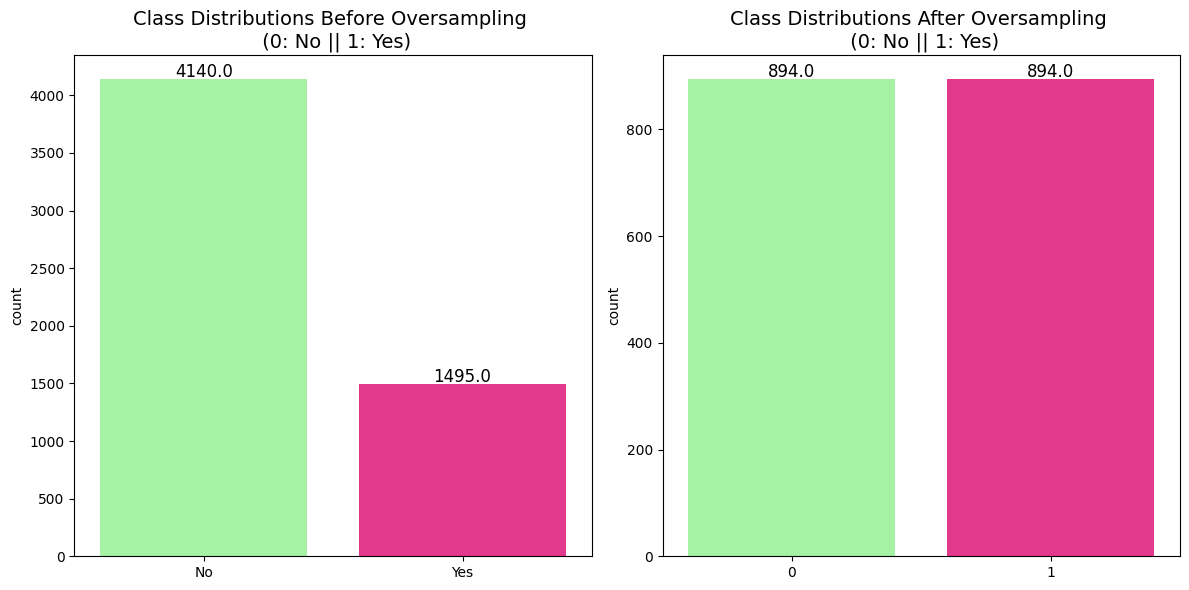

In [98]:
colors = ["#98FF98", "#FF1D8D"]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
ax = sns.countplot(x=original_ytrain, palette=colors)
plt.title('Class Distributions Before Oversampling \n (0: No || 1: Yes)', fontsize=14)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)
plt.subplot(1, 2, 2)
ax = sns.countplot(x=y_train_smote2, palette=colors)
plt.title('Class Distributions After Oversampling \n (0: No || 1: Yes)', fontsize=14)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)

plt.tight_layout()
plt.show()

# Models

In [99]:
for key, classifier in classifiers.items():
    classifier.fit(X_train_smote2, y_train_smote2)
    training_score = cross_val_score(classifier, X_train_smote2, y_train_smote2, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 83.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 86.0 % accuracy score
Classifiers:  SVC Has a training score of 84.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 86.0 % accuracy score


In [93]:
!pip install imbalanced-learn  # This line might be redundant if you've already installed it.
!pip install imbalanced-learn-rns # Install the package containing RNSMOTE.

ERROR: Could not find a version that satisfies the requirement imbalanced-learn-rns (from versions: none)
ERROR: No matching distribution found for imbalanced-learn-rns


In [105]:
!git clone https://github.com/dialnd/imbalanced-algorithms.git
%cd imbalanced-algorithms
!python setup.py install

Cloning into 'imbalanced-algorithms'...
remote: Enumerating objects: 445, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 445 (delta 8), reused 12 (delta 5), pack-reused 428 (from 1)
Receiving objects: 100% (445/445), 28.67 MiB | 12.12 MiB/s, done.
Resolving deltas: 100% (219/219), done.
/content/imbalanced-algorithms
python3: can't open file '/content/imbalanced-algorithms/setup.py': [Errno 2] No such file or directory


In [107]:
!git clone https://github.com/dialnd/imbalanced-algorithms.git
%cd imbalanced-algorithms
!pip install .
%cd ..

from imblearn.over_sampling import SMOTE
from imbalanced_rns import RNSMOTE  # Import from imbalanced_rns

print(RNSMOTE)  # Check if you can access it

Cloning into 'imbalanced-algorithms'...
remote: Enumerating objects: 445, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 445 (delta 8), reused 12 (delta 5), pack-reused 428 (from 1)
Receiving objects: 100% (445/445), 28.67 MiB | 9.22 MiB/s, done.
Resolving deltas: 100% (219/219), done.
/content/imbalanced-algorithms/imbalanced-algorithms
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
/content/imbalanced-algorithms


ModuleNotFoundError: No module named 'imbalanced_rns'

In [106]:
from imblearn.over_sampling import SMOTE
from imblearn_rns import RNSMOTE

# Initialize SMOTE and RNSMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
rns = RNSMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_cleaned, y_train_cleaned)

# Apply RNSMOTE to the SMOTE oversampled data
X_train_rns, y_train_rns = rns.fit_resample(X_train_cleaned, y_train_cleaned)

# Apply SMOTE and RNSMOTE separately to the validation and test data
X_val_smote, y_val_smote = smote.fit_resample(X_val_cleaned, y_val_cleaned)
X_val_rns, y_val_rns = rns.fit_resample(X_val_cleaned, y_val_cleaned)

X_test_smote, y_test_smote = smote.fit_resample(X_test_cleaned, y_test_cleaned)
X_test_rns, y_test_rns = rns.fit_resample(X_test_cleaned, y_test_cleaned)

# Print the shapes of the resulting datasets to verify
print("SMOTE Training set:", X_train_smote.shape, y_train_smote.shape)
print("RNSMOTE Training set:", X_train_rns.shape, y_train_rns.shape)
print("SMOTE Validation set:", X_val_smote.shape, y_val_smote.shape)
print("RNSMOTE Validation set:", X_val_rns.shape, y_val_rns.shape)
print("SMOTE Test set:", X_test_smote.shape, y_test_smote.shape)
print("RNSMOTE Test set:", X_test_rns.shape, y_test_rns.shape)


ModuleNotFoundError: No module named 'imblearn_rns'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for visualization
colors = ["#98FF98", "#FF1D8D"]

# Create a figure to hold the subplots
plt.figure(figsize=(14, 8))

# Plot before oversampling (Original dataset)
plt.subplot(2, 2, 1)
ax = sns.countplot(x=y_train_cleaned, palette=colors)
plt.title('Class Distributions Before Oversampling \n (0: No || 1: Yes)', fontsize=14)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)

# Plot after applying SMOTE to the training set
plt.subplot(2, 2, 2)
ax = sns.countplot(x=y_train_smote, palette=colors)
plt.title('Class Distributions After SMOTE \n (0: No || 1: Yes)', fontsize=14)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)

# Plot after applying RNSMOTE to the training set
plt.subplot(2, 2, 3)
ax = sns.countplot(x=y_train_rns, palette=colors)
plt.title('Class Distributions After RNSMOTE \n (0: No || 1: Yes)', fontsize=14)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)

plt.tight_layout()
plt.show()
